In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d

In this file, conversion from a data file with the coordinates of some profile will be normalized (to have a total chord length of 1), ordered and stored (in four arrays going from 0 to 1 in the x-axis with the respective upper and lower surfaces). One inconvenient that the code must face is that positive y values are usually separated with two spaces '  ' while negative values have just one space ' '.

In [90]:
# set the name of the file with the coordinates (some example files from airfoiltools are provided)
filename = "b29"
file = open(filename, "r")
file_str = file.read().replace("  ", " ")

# delete the file with two spaces
os.system("rm %s" %filename)

# save the file with just one space
file = open(filename, "w")
file.write(file_str)
file.close()

In [91]:
# import the file (assuming that the first line contains the name of the airfoil)
airfoil_pts = np.genfromtxt(filename, skip_header=1, delimiter=' ')

# indexes of the matrix
slices = np.linspace(0, len(airfoil_pts)-1, len(airfoil_pts))

# y=0 intercept of the airfoil
y_inter = airfoil_pts[:,1] == 0

# position of the y-intercept refered to index
print(slices[y_inter])

[ 0. 18. 38.]


In [92]:
# positive-y surface of the airfoil
pos_side = airfoil_pts[:int(slices[y_inter][1]+1), :]
pos_side = pos_side[pos_side[:, 0].argsort()]

# negative-y surface of the airfoil
neg_side = airfoil_pts[int(slices[y_inter][1]):, :]
neg_side = neg_side[neg_side[:, 0].argsort()]

# extract the x and y for both upper and lower surface
xu = pos_side[:,0]
yu = pos_side[:,1]
xl = neg_side[:,0]
yl = neg_side[:,1]

In [93]:
# functions taken from https://github.com/jlobatop/GA-CFD-MO/tree/master/airfoil-parametrization/NACA4/NACA_4digit.ipynb

def simple_grading(N, expRatio, L):
    # size of each cell array
    delta = np.zeros(N) 
    # position of the nodes
    nodes = np.zeros(N+1) 

    # value of k for all the line
    kVal = expRatio**((1)/(N-1)) 
    # increment of k for each cell
    k = np.zeros(N)

    # compute that incremental k
    for i in range(N):
        k[i] = kVal**(i) 

    # first cell size 
    deltaS = L/np.sum(k)
    # size of each cell
    delta = deltaS*k 
    
    # compute the location of the nodes
    for i in range(N):
        nodes[i+1] = nodes[i] + delta[i]

    return nodes

def multi_grading(perc, cells, eps, N, L): 
    
    # some initial shape and value comprobations
    if np.sum(perc) != 1:
        raise ValueError('Bad percentage array input')
        return

    if np.sum(cells) != 1:
        raise ValueError('Bad cell array input')
        return
    
    if np.shape(perc)[0] != np.shape(cells)[0] or np.shape(perc)[0] != np.shape(eps)[0] or np.shape(cells)[0] != np.shape(eps)[0]:
        raise ValueError('Non equal vector definition')
        return

    # cells per segment
    segmentN = (N*cells) 

    # in case there are decimal values
    restCells = np.modf(segmentN)[0] 

    # integer value of the cells
    segmentN = np.trunc(segmentN) 
    
    # distribution of the 'decimal' parts of the cells
    i = np.sum(restCells) 

    # compute the correct subdivisions of the cells
    while i > 0:
        segmentN[np.argmax(restCells)] = segmentN[np.argmax(restCells)] + int(i)
        restCells[np.argmax(restCells)] = 0
        i -= 1
   
    # length per segment
    segmentL = (L*perc) 

    # number of nodes    
    nodes = np.zeros(N+1)
    
    # compute the location of each node in the line
    for i in range(np.shape(perc)[0]):
        nodesTemp = simple_grading(int(segmentN[i]), eps[i], segmentL[i])
        for j in range(np.shape(nodesTemp)[0]):
            if i == 0:
                nodes[j] = nodesTemp[j]
            else:
                nodes[int(np.cumsum(segmentN)[i-1]) + j] = nodesTemp[j] + nodes[int(np.cumsum(segmentN)[i-1])]

    return nodes

def airfoilTrueX(newX, xu, yu, xl, yl):
    # get the interpolation functions for both surfaces
    yuF = interp1d(xu, yu, kind='cubic')
    ylF = interp1d(xl, yl, kind='cubic')
    # evaluate the function in the new x-axis coordinates
    yuAxis = yuF(newX)
    ylAxis = ylF(newX)
    # return the new y-axis coordinates referred to newX
    return yuAxis, ylAxis

In [101]:
# definition of the grading
perc = np.array([0.3,0.4,0.3])
cells = np.array([0.6,0.2,0.2])
exp = np.array([12,1.2,0.2])

# selection of the new xpoints with twice as many as before
xAxis = multi_grading(perc, cells, exp, 100, 0.9999)

# recompute the airfoil in those new point locations
nYu, nYl = airfoilTrueX(xAxis, xu, yu, xl, yl)

(-0.005, 0.01)

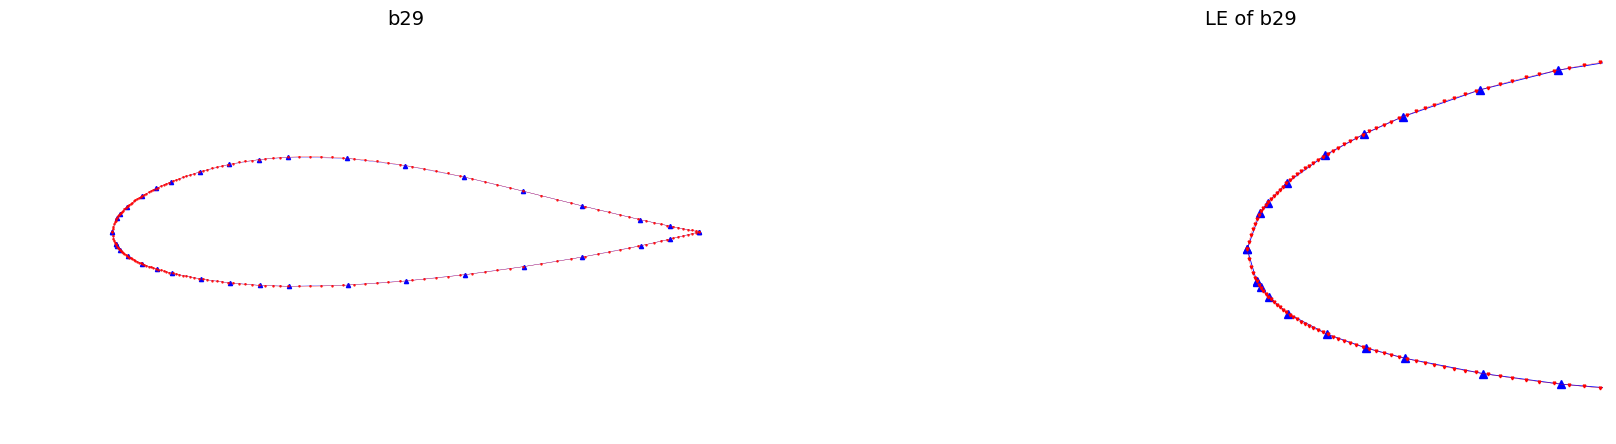

In [110]:
# plot both the old and new airfoils to see the differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5), dpi = 100)

ax1.axis('equal')
ax1.axis('off')
ax1.plot(xu,yu,'^-b', lw = '0.2',markersize=3)
ax1.plot(xl,yl,'^-b', lw = '0.2',markersize=3)
ax1.plot(xAxis,nYu,'v-r', lw = '0.2',markersize=1)
ax1.plot(xAxis,nYl,'v-r', lw = '0.2',markersize=1)
ax1.set_title(filename,fontsize=14)
ax1.set_xlim(-0.1,1.1)

ax2.axis('equal')
ax2.axis('off')
ax2.plot(xu,yu,'^-b', lw = '0.6',markersize=6)
ax2.plot(xl,yl,'^-b', lw = '0.6',markersize=6)
ax2.plot(xAxis,nYu,'v-r', lw = '0.2',markersize=2)
ax2.plot(xAxis,nYl,'v-r', lw = '0.2',markersize=2)
ax2.set_title('LE of %s' %filename,fontsize=14)
ax2.set_xlim([-0.005,0.01])